# CNN + LSTM + Dense 
Model: Embed mask, Conv1D, LSTM no seq, Dense, Dropout (overfit, bounce up & down)

Coding len 2000-4000

Cross validation 5 folds 5 epochs,  accuracy mean 53.01% +/- 1.14, F1 mean 43.31% +/- 3.15

2 hr 27 min on CoLab GPU

In [2]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-12-18 17:07:17.384944
Python 3.8.16
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [3]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import Attention
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
RCI_THRESHOLD=0.0
CFILTERS=62
FILTERSIZE=8
RCELLS=16
EPOCHS=20
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=2000
MAXLEN=4000   

In [4]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/


In [5]:
GENES_FILE =    'CNRCI_coding_train_genes.csv'
RCI_FILE =      'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_coding_train_counts.K4.gc42.csv'

In [6]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
CELL_LINE_NUMBER=1
all_cell_lines = get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 1 = H1.hESC


## Data Load

In [7]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields[0]
                    rci_val = fields[cell_line+1]
                    if rci_val != "nan":
                        # Convert string nan to float(nan)
                        gene_to_rci[gene_id] = float(rci_val)
        return gene_to_rci
    
    def seq_to_kmer_values(self,rna,K):
        # The cache may represent more than one K. Probably not a problem.
        N_indicator = 0 # indicator value
        vec=[] # seq converted to list of K-mers 
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def rci_to_label(self,rci):
        CYTO_LABEL = 1
        NUCLEAR_LABEL = 0
        # cnrci = log (cyto-to-nuclear ratio)
        # rci > 0 implies cytoplasmic
        if rci > RCI_THRESHOLD:
            return CYTO_LABEL
        return NUCLEAR_LABEL

    def load_sequence(self,filepath):
        labels=[]
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        rci_val = gene_to_rci[gene_id]
                        rci_label = self.rci_to_label(rci_val)
                        labels.append(rci_label)
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        return labels,allids,allseq
    
loader = DataLoader()
# test it
print(loader.seq_to_kmer_values('AAAA',3))
print(loader.seq_to_kmer_values('CATT',3))
print(loader.seq_to_kmer_values('TTGA',3))
print(loader.seq_to_kmer_values('TTTN',3))
# test it
print(loader.rci_to_label(-0.9))
print(loader.rci_to_label(1.1))

[1, 1]
[20, 16]
[63, 57]
[64, 0]
0
1


In [8]:
print(datetime.now())
print("Load RCI values...")
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,CELL_LINE_NUMBER)
print('Num RCI:', len(gene_to_rci.keys()))
print('Example RCI:', list(gene_to_rci.items())[:3])
print("Load genes...")
all_genes = list(gene_to_rci.keys())
print(datetime.now())
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
labels,allids,allseq = loader.load_sequence(filepath)
print(datetime.now())
print('Num IDs:',len(allids))
print('Example IDs:',[allids[x] for x in [10, 20, 30, 40]] )
print('Count',np.count_nonzero(labels),'ones out of',len(labels),'labels.')
print('Example labels:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num counts:',len(allseq))
print('Example sequence:',allseq[3])
loader = None  # drop K-mer cache to save RAM

2022-12-18 17:07:45.770260
Load RCI values...
Num RCI: 13000
Example RCI: [('ENSG00000000003', 1.85734), ('ENSG00000000005', 5.88264), ('ENSG00000000419', 2.58954)]
Load genes...
2022-12-18 17:07:47.516029
Load sequence...
2022-12-18 17:08:15.082546
Num IDs: 18084
Example IDs: [('ENSG00000162571', 'ENST00000379289.6'), ('ENSG00000131584', 'ENST00000354700.10'), ('ENSG00000162576', 'ENST00000477278.3'), ('ENSG00000197530', 'ENST00000505820.7')]
Count 8030 ones out of 18084 labels.
Example labels: [0, 0, 0, 0]
Num counts: 18084
Example sequence: [60, 238, 182, 213, 81, 67, 11, 43, 171, 169, 164, 142, 54, 216, 95, 122, 229, 147, 75, 44, 175, 186, 229, 148, 78, 54, 216, 94, 118, 215, 89, 100, 142, 56, 223, 122, 231, 153, 98, 136, 31, 122, 230, 150, 87, 91, 107, 170, 168, 159, 122, 230, 151, 89, 97, 132, 13, 52, 206, 54, 216, 94, 118, 214, 86, 87, 91, 108, 175, 185, 225, 130, 6, 23, 91, 107, 171, 171, 170, 167, 155, 106, 168, 159, 123, 234, 165, 147, 73, 34, 133, 17, 67, 9, 35, 139, 41, 162

## Model

In [9]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    rnn1_layer = Bidirectional( LSTM(RCELLS, return_sequences=False) )
    den1_layer = Dense(RCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    rnn.add(embed_layer)
    rnn.add(cnn1_layer)
    rnn.add(rnn1_layer)
    rnn.add(den1_layer)
    rnn.add(drop_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [10]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2022-12-18 17:08:15.123848
COMPILE
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3997, 4)           1028      
                                                                 
 conv1d (Conv1D)             (None, 3990, 62)          2046      
                                                                 
 bidirectional (Bidirectiona  (None, 32)               10112     
 l)                                                              
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                     

## Training

In [11]:
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,pred_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.threshold = pred_threshold # e.g. score>0.5 => class 1
    
    def get_gene_subset(self,all_genes,sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes
    
    def get_X_y(self,gene_set,allids,allX,allY):
        cnt = len(allids)
        subsetX=[]
        subsetY=[]
        if cnt != len(allX) or cnt!= len(allY):
            raise Exception('Lengths differ')
        for i in range(cnt):
            gene_id,tran_id = allids[i]
            if gene_id in gene_set:
                oneX = allX[i]
                oneY = allY[i]
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        for train_index,valid_index in splitter.split(all_genes):
            fold += 1
            print('Fold',fold)
            train_genes = self.get_gene_subset(all_genes,train_index)
            valid_genes = self.get_gene_subset(all_genes,valid_index)
            X_train,y_train = self.get_X_y(train_genes,allids,allseq,labels)
            X_valid,y_valid = self.get_X_y(valid_genes,allids,allseq,labels)

            print('Training example')
            print(X_train[0])

            print('Train sizes',X_train.shape,y_train.shape)
            print('Valid sizes',X_valid.shape,y_valid.shape)
            print('Train set ones/size',
                  np.count_nonzero(y_train),'/',len(y_train))
            print('Valid set ones/size',
                  np.count_nonzero(y_valid),'/',len(y_valid))

            print("BUILD MODEL")
            model=build_model()

            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                    epochs=self.epochs, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                    validation_data=(X_valid,y_valid) )

            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print("Compute valiation accuracy")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0) 
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            yhat_classes=np.where(yhat_pred > self.threshold, 1, 0)
            print('Predicted zeros and ones',np.count_nonzero(yhat_classes==0),np.count_nonzero(yhat_classes==1))
            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%% F1: %.2f%%' % (accuracy,precision,recall,f1)) 
            print(datetime.now())
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1

2022-12-18 17:08:18.561350
2022-12-18 17:08:18.563143
splitting
Fold 1
Training example
[167 155 106 ...   0   0   0]
Train sizes (14388, 3997) (14388, 1)
Valid sizes (3696, 3997) (3696, 1)
Train set ones/size 6390 / 14388
Valid set ones/size 1640 / 3696
BUILD MODEL
COMPILE
FIT
2022-12-18 17:08:23.047390
Epoch 1/20
450/450 [==============================] - 99s 194ms/step - loss: 0.6880 - accuracy: 0.5551 - val_loss: 0.6859 - val_accuracy: 0.5557
Epoch 2/20
450/450 [==============================] - 88s 196ms/step - loss: 0.6818 - accuracy: 0.5654 - val_loss: 0.6832 - val_accuracy: 0.5601
Epoch 3/20
450/450 [==============================] - 88s 195ms/step - loss: 0.6743 - accuracy: 0.5853 - val_loss: 0.6838 - val_accuracy: 0.5644
Epoch 4/20
450/450 [==============================] - 87s 194ms/step - loss: 0.6753 - accuracy: 0.5803 - val_loss: 0.6931 - val_accuracy: 0.5568
Epoch 5/20
450/450 [==============================] - 88s 196ms/step - loss: 0.6713 - accuracy: 0.5892 - val_loss:

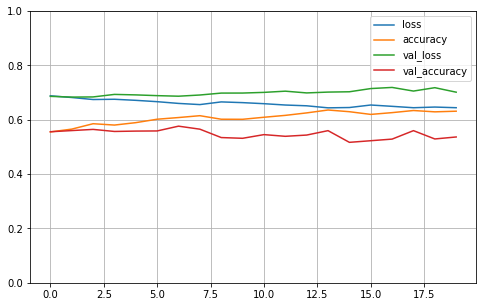

Compute valiation accuracy
2022-12-18 17:37:48.997660
Range of scores: 0.19116879 to 0.8299971
Predicted zeros and ones 2439 1257
Accuracy: 53.65% Precision: 47.10% Recall: 36.10% F1: 40.87%
2022-12-18 17:38:00.027190
Fold 2
Training example
[167 155 106 ...   0   0   0]
Train sizes (14453, 3997) (14453, 1)
Valid sizes (3631, 3997) (3631, 1)
Train set ones/size 6483 / 14453
Valid set ones/size 1547 / 3631
BUILD MODEL
COMPILE
FIT
2022-12-18 17:38:04.405216
Epoch 1/20
452/452 [==============================] - 92s 198ms/step - loss: 0.6875 - accuracy: 0.5473 - val_loss: 0.6837 - val_accuracy: 0.5635
Epoch 2/20
452/452 [==============================] - 88s 195ms/step - loss: 0.6779 - accuracy: 0.5770 - val_loss: 0.7297 - val_accuracy: 0.4478
Epoch 3/20
452/452 [==============================] - 87s 193ms/step - loss: 0.6701 - accuracy: 0.5926 - val_loss: 0.6863 - val_accuracy: 0.5690
Epoch 4/20
452/452 [==============================] - 87s 192ms/step - loss: 0.6697 - accuracy: 0.5934 - 

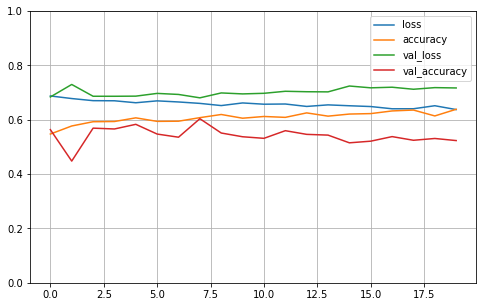

Compute valiation accuracy
2022-12-18 18:07:07.257261
Range of scores: 0.10316177 to 0.8055925
Predicted zeros and ones 2089 1542
Accuracy: 52.33% Precision: 44.03% Recall: 43.89% F1: 43.96%
2022-12-18 18:07:18.824022
Fold 3
Training example
[167 155 106 ...   0   0   0]
Train sizes (14355, 3997) (14355, 1)
Valid sizes (3729, 3997) (3729, 1)
Train set ones/size 6379 / 14355
Valid set ones/size 1651 / 3729
BUILD MODEL
COMPILE
FIT
2022-12-18 18:07:23.174295
Epoch 1/20
449/449 [==============================] - 90s 194ms/step - loss: 0.6877 - accuracy: 0.5558 - val_loss: 0.6857 - val_accuracy: 0.5575
Epoch 2/20
449/449 [==============================] - 87s 193ms/step - loss: 0.6812 - accuracy: 0.5657 - val_loss: 0.6857 - val_accuracy: 0.5573
Epoch 3/20
449/449 [==============================] - 87s 193ms/step - loss: 0.6800 - accuracy: 0.5682 - val_loss: 0.6852 - val_accuracy: 0.5591
Epoch 4/20
449/449 [==============================] - 87s 193ms/step - loss: 0.6719 - accuracy: 0.5890 - 

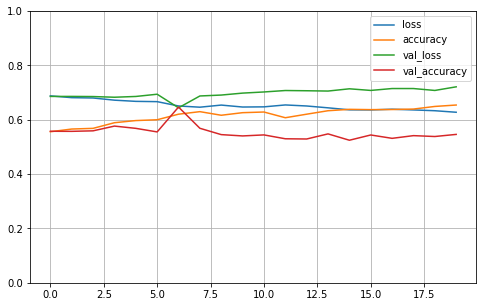

Compute valiation accuracy
2022-12-18 18:36:13.455960
Range of scores: 0.13053717 to 0.7910854
Predicted zeros and ones 2319 1410
Accuracy: 54.60% Precision: 48.51% Recall: 41.43% F1: 44.69%
2022-12-18 18:36:23.807746
Fold 4
Training example
[167 155 106 ...   0   0   0]
Train sizes (14515, 3997) (14515, 1)
Valid sizes (3569, 3997) (3569, 1)
Train set ones/size 6471 / 14515
Valid set ones/size 1559 / 3569
BUILD MODEL
COMPILE
FIT
2022-12-18 18:36:28.212859
Epoch 1/20
454/454 [==============================] - 91s 193ms/step - loss: 0.6878 - accuracy: 0.5524 - val_loss: 0.6831 - val_accuracy: 0.5573
Epoch 2/20
454/454 [==============================] - 87s 191ms/step - loss: 0.6799 - accuracy: 0.5664 - val_loss: 0.6780 - val_accuracy: 0.5677
Epoch 3/20
454/454 [==============================] - 87s 191ms/step - loss: 0.6726 - accuracy: 0.5901 - val_loss: 0.6767 - val_accuracy: 0.5769
Epoch 4/20
454/454 [==============================] - 87s 191ms/step - loss: 0.6688 - accuracy: 0.5955 - 

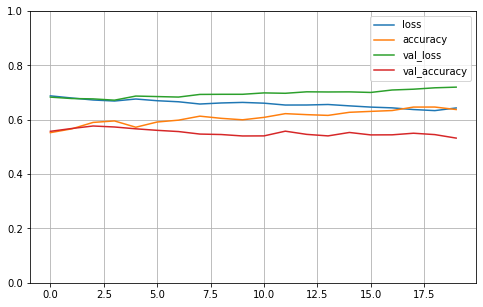

Compute valiation accuracy
2022-12-18 19:05:34.397888
Range of scores: 0.17628889 to 0.82528657
Predicted zeros and ones 1915 1654
Accuracy: 53.24% Precision: 46.67% Recall: 49.52% F1: 48.05%
2022-12-18 19:05:45.293660
Fold 5
Training example
[160 126 247 ...   0   0   0]
Train sizes (14625, 3997) (14625, 1)
Valid sizes (3459, 3997) (3459, 1)
Train set ones/size 6397 / 14625
Valid set ones/size 1633 / 3459
BUILD MODEL
COMPILE
FIT
2022-12-18 19:05:49.585826
Epoch 1/20
458/458 [==============================] - 90s 191ms/step - loss: 0.6853 - accuracy: 0.5636 - val_loss: 0.6936 - val_accuracy: 0.5322
Epoch 2/20
458/458 [==============================] - 87s 190ms/step - loss: 0.6784 - accuracy: 0.5809 - val_loss: 0.6905 - val_accuracy: 0.5435
Epoch 3/20
458/458 [==============================] - 87s 189ms/step - loss: 0.6700 - accuracy: 0.5915 - val_loss: 0.6881 - val_accuracy: 0.5554
Epoch 4/20
458/458 [==============================] - 87s 190ms/step - loss: 0.6628 - accuracy: 0.6076 -

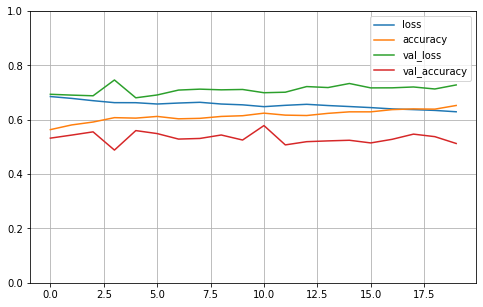

Compute valiation accuracy
2022-12-18 19:34:52.354169
Range of scores: 0.13812068 to 0.8652231
Predicted zeros and ones 2330 1129
Accuracy: 51.26% Precision: 47.65% Recall: 32.95% F1: 38.96%
2022-12-18 19:35:01.888183

Cross validation 5 folds 20 epochs
 accuracy mean 53.01% +/- 1.14
 precision mean 46.79% +/- 1.51
 recall mean 40.78% +/- 5.83
 F1 mean 43.31% +/- 3.15
2022-12-18 19:35:01.894336


In [12]:
print(datetime.now())
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cv_accuracy, cv_precision, cv_recall, cv_f1 = cvdo.do_cross_validation()   
print("Cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
print(datetime.now())